In [18]:
from scipy.optimize import minimize
from Truss_2D import Truss_2D
import numpy as np
from random import random
import matplotlib.pyplot as plt 

### Step 1: Initialize Design Variables

In [2]:
area_old = 50

### Step 2.1: Define Model Analysis

In [3]:
def Truss_solver(cross_sectional_areas):
    nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
    elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
    supports = {5:[1,1], 6:[1,1]}
    forces = {2:[0,-100], 4:[0,-100]}
    elasticity = {key: 10_000 for key in elements}
    cross_area = {1:cross_sectional_areas[0], 2:cross_sectional_areas[1], 3:cross_sectional_areas[2], 4:cross_sectional_areas[3], 5:cross_sectional_areas[4],
                  6:cross_sectional_areas[5], 7:cross_sectional_areas[6], 8:cross_sectional_areas[7], 9:cross_sectional_areas[8], 10:cross_sectional_areas[9]}

    Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                    elements= elements,
                                    supports= supports,
                                    forces = forces,
                                    elasticity= elasticity,
                                    cross_area= cross_area)

    Ten_Bar_Truss_Case_1.Solve()

    return (Ten_Bar_Truss_Case_1.member_lengths_, Ten_Bar_Truss_Case_1.member_stresses_)

#### Step 2.2: Define Objective Function

In [4]:
def Objective_Function(areas):
    
    member_lengths, _ = Truss_solver(areas)    
    total_area = np.array(areas)
    total_member_lengths = []
    
    for length in member_lengths:
        total_member_lengths.append(member_lengths[length])

    total_member_lengths = np.array(total_member_lengths)

    weight = total_area.dot(np.array(total_member_lengths))

    return weight.sum() * 0.1 # lb/in^3

### Step 3: Define Algorithm

Step 3.1: Initialize Parameters

In [23]:
# intermediate variables 
k = 0.05 # move variable's constant
M = 300 # number of loops to be performed
T0 = 1000 # initial temperature
N = 15 # initial number of neighbors per search space loop
alpha = 0.85 # cooling parameter

In [24]:
temp = [] # storing of values for the temperature per loop M
min_weight = [] # storing best value of the objective function per loop M
area_list = [] # storing x values per loop for plotting purposes

Step 3.2: Simulated Annealing Algorithm

In [25]:
def Random_Number_Check(objective_old, objective_new, Init_temp):
    return 1/((np.exp(objective_old - objective_new)) / Init_temp)

In [26]:
for m in range(M):
    for n in range(N):

        random_area = random()
        
        if random_area >= 0.5:
            area_new = k*random_area
        else:
            area_new = -k*random_area  

        area_new = area_old + area_new

        areas_new_array = [area_new for i in range(10)]
        areas_old_array = [area_old for i in range(10)]

        weight_computed = Objective_Function(areas_new_array)
        weight_old = Objective_Function(areas_old_array)

        check = Random_Number_Check(weight_computed, weight_old, T0)
        random_number = random()

        if weight_computed <= weight_old:
            area_old = area_new
        elif random_number <= check:
            area_old = area_new
        else:
            area_old = area_old

    temp.append(T0)
    min_weight.append(weight_old)
    area_list.append(area_old)
    
    T0 = alpha * T0

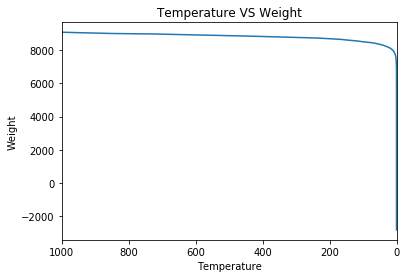

In [28]:
plt.xlim(1000,0)
plt.xlabel('Temperature')
plt.ylabel('Weight')
plt.title('Temperature VS Weight')
plt.plot(temp, min_weight)

In [30]:
area_list[-1]

-6.7405496243145

In [31]:
nodes = {1: [720,360], 2:[720,0], 3:[360,360], 4:[360,0], 5:[0,360], 6:[0,0]}
elements = {1:[5,3], 2:[3,1], 3:[6,4], 4:[4,2], 5:[3,4], 6:[1,2], 7:[5,4], 8:[6,3], 9:[3,2], 10:[4,1]}
supports = {5:[1,1], 6:[1,1]}
forces = {2:[0,-100], 4:[0,-100]}
elasticity = {key: 10_000 for key in elements}
cross_area = {key: area_list[-1] for key in range(1,11)}

Ten_Bar_Truss_Case_1 = Truss_2D(nodes = nodes,
                                elements= elements,
                                supports= supports,
                                forces = forces,
                                elasticity= elasticity,
                                cross_area= cross_area)

Ten_Bar_Truss_Case_1.Solve()

In [32]:
Ten_Bar_Truss_Case_1.displacements_

{1: [-1.25771, 5.63029],
 2: [1.4127, 5.84459],
 3: [-1.04341, 2.484],
 4: [1.09292, 2.67354],
 5: [0.0, 0.0],
 6: [0.0, 0.0]}